<div align="center" style="font-family: 'Garamond', serif; color: #333333;">
    <h2 style="color: #8b0000; text-decoration: underline; font-variant: small-caps;">
        <span style="font-family: 'Courier New', monospace;">&#9472;</span>
        Reinforcement Learning Summer 2024
        <span style="font-family: 'Courier New', monospace;">&#9472;</span>
    </h2>
    <h2 style="color: #6c757d;">Prof. Dr. Frank Kirchner</h2>
    <h4 style="color: #6c757d; font-style: italic;">Exercise Sheet – II</h4>
    <h5 style="color: #6c757d;">Due: 14.05.25</h5>
    <hr style="border-top: 2px solid #8b0000; width: 100%;">
</div>

### Group = 9  

### Muhammad Ahsan  
**Email:** muahsan@uni-bremen.de

### Huzaifa Sajid  
**Email:** hsajid@uni-bremen.de

### Ahtasham Ilyas  
**Email:** o_yfodc2@uni-bremen.de


# Problem 2.1: Monte Carlo Methods (10 Points)

In this task, you are going to implement Monte Carlo learning for a cliffwalking environment.


- The agent moves on a 4x12 grid.
- The observation space consists of the position of the agent.
- The agent starts at (3,0), goal at (3,11).
- The agent moves until he reaches the goal without falling into a cliff.
- The cliff is at (3,1) to (3,10).
- Falling into the cliff gives a reward of -100 and resets the agent to start.
- Each step gives -1 reward.
- The episode ends when the agent reaches the goal.
- Resetting the environment sets the starting values to the start of the grid.


### **2.1 A: (3 Points)** Implement the Cliffwalking environment in the following cell. The environment must not be implemented with the gymnasium package but has to follow the conventions of their environments (names, methods, returned values, etc.). Rendering is not necessary as the results can be output via the print function. test your implementation thoroughly.

In [1]:
import numpy as np

class CliffWalkingEnv:
    def __init__(self):
        self.height = 4
        self.width = 12
        self.start = (3, 0)
        self.goal = (3, 11)
        self.cliff = [(3, i) for i in range(1, 11)]

        # Define action space: 0=Up, 1=Right, 2=Down, 3=Left
        self.action_space = 4
        self.observation_space = self.height * self.width

        self.agent_pos = self.start

    def reset(self):
        self.agent_pos = self.start
        return self._state()

    def step(self, action):
        row, col = self.agent_pos

        # Move based on action
        if action == 0:    # Up
            row = max(row - 1, 0)
        elif action == 1:  # Right
            col = min(col + 1, self.width - 1)
        elif action == 2:  # Down
            row = min(row + 1, self.height - 1)
        elif action == 3:  # Left
            col = max(col - 1, 0)

        new_pos = (row, col)

        # Check if new position is cliff
        if new_pos in self.cliff:
            reward = -100
            self.agent_pos = self.start
            done = False
        elif new_pos == self.goal:
            reward = -1
            self.agent_pos = new_pos
            done = True
        else:
            reward = -1
            self.agent_pos = new_pos
            done = False

        return self._state(), reward, done, {}

    def _state(self):
        # Converts (row, col) to state index (0 to 47)
        return self.agent_pos[0] * self.width + self.agent_pos[1]


In [2]:
env = CliffWalkingEnv()

state = env.reset()
print(f"Start state: {state}")

next_state, reward, done, _ = env.step(1)  # move right
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")


Start state: 36
Next state: 36, Reward: -100, Done: False


### **2.1 B: (3 Points)** Implement the First Visit Monte Carlo learning from the lecture in the following cell. We will use the state-action-values for this task and you should use the predefined variable *q_values* (see hint below) for that. Run the learning for different number of episodes until you are happy with the success. 

In [3]:
import numpy as np
import random
from collections import defaultdict

class MonteCarlo:

    def __init__(self, env, gamma=1.0, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize state-action values to zeros
        self.q_values = np.zeros((env.observation_space, env.action_space))

        # Keep track of returns for averaging
        self.returns = defaultdict(list)

    def _policy(self, state):
        # Epsilon-greedy policy
        if random.random() < self.epsilon:
            return random.randint(0, self.env.action_space - 1)
        else:
            return np.argmax(self.q_values[state])

    def learning(self, episodes):
        for ep in range(episodes):
            episode = []
            state = self.env.reset()
            done = False

            # Generate one episode
            while not done:
                action = self._policy(state)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state

            # Track first visits
            visited = set()
            G = 0

            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = self.gamma * G + reward

                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[(state, action)].append(G)
                    self.q_values[state, action] = np.mean(self.returns[(state, action)])

            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}/{episodes} completed.")


In [4]:
env = CliffWalkingEnv()
mc_agent = MonteCarlo(env)
mc_agent.learning(episodes=1000)

# Example: Check learned Q-values
print(mc_agent.q_values)


Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.
[[-2.43842105e+02 -2.94774436e+01 -2.92466667e+02 -3.75166667e+02]
 [-1.32676471e+02 -2.11374359e+01 -1.47969697e+02 -1.70407407e+02]
 [-4.05483871e+01 -1.65335366e+01 -4.61739130e+01 -2.03818182e+02]
 [-3.80000000e+01 -3.64848485e+01 -1.51628392e+01 -3.35787879e+02]
 [-3.04375000e+01 -1.17438776e+01 -2.27805556e+02 -3.75000000e+01]
 [-3.16216216e+01 -1.02880000e+01 -3.92592593e+01 -3.16400000e+01]
 [-2.30000000e+01 -9.17800000e+00 -4.03461538e+01 -3.70344828e+01]
 [-2.25454545e+01 -8.04504505e+00 -4.47407407e+01 -3.42812500e+01]
 [-3.69482759e+02 -6.84400000e+00 -9.35769231e+01 -4.27586207e+01]
 [-7.84000000e+00 -5.48448448e+00 -9.12500000e+00 -2.13571429e+01]
 [-1.30645161e+01 -4.22300000e+00 -1.98695652e+01

### **2.1 C: (1 Point)** Implement an evaluate_policy() function in the cell below, that uses the obtained state-action-values to run *n* episodes in the CliffWalking environment. Collect the episode wise rewards and plot them for further analysis.

In [8]:
from matplotlib import pyplot as plt

def evaluate_policy(env, q_values, n):
    episode_rewards = []

    for _ in range(n):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Always take the best action (greedy policy)
            action = np.argmax(q_values[state])
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        episode_rewards.append(total_reward)

    # Plotting episode-wise rewards
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Policy Evaluation over Episodes')
    plt.grid(True)
    plt.show()


Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.


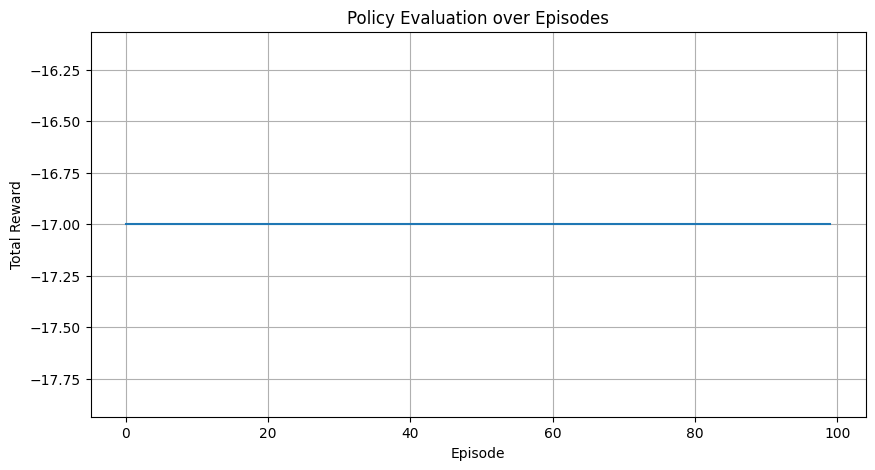

In [9]:
env = CliffWalkingEnv()
learner1 = MonteCarlo(env)
learner1.learning(episodes=1000)

evaluate_policy(env, learner1.q_values, n=100)


### **2.1 D: (2 Points)** Also implement the every visit MC. Add an attribute in the class initialization method to choose the method.

In [10]:
import numpy as np
import random
from collections import defaultdict

class MonteCarlo:

    def __init__(self, env, gamma=1.0, epsilon=0.1, method="first"):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method.lower()  # 'first' or 'every'

        self.q_values = np.zeros((env.observation_space, env.action_space))
        self.returns = defaultdict(list)

    def _policy(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.env.action_space - 1)
        return np.argmax(self.q_values[state])

    def learning(self, episodes):
        for ep in range(episodes):
            episode = []
            state = self.env.reset()
            done = False

            # Generate one full episode
            while not done:
                action = self._policy(state)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                state = next_state

            # Calculate returns and update Q-values
            G = 0
            visited = set()

            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = self.gamma * G + reward

                if self.method == "first":
                    if (state, action) not in visited:
                        self.returns[(state, action)].append(G)
                        self.q_values[state, action] = np.mean(self.returns[(state, action)])
                        visited.add((state, action))

                elif self.method == "every":
                    self.returns[(state, action)].append(G)
                    self.q_values[state, action] = np.mean(self.returns[(state, action)])

            if (ep + 1) % 100 == 0:
                print(f"{self.method.title()} Visit - Episode {ep + 1}/{episodes} complete")


First Visit - Episode 100/1000 complete
First Visit - Episode 200/1000 complete
First Visit - Episode 300/1000 complete
First Visit - Episode 400/1000 complete
First Visit - Episode 500/1000 complete
First Visit - Episode 600/1000 complete
First Visit - Episode 700/1000 complete
First Visit - Episode 800/1000 complete
First Visit - Episode 900/1000 complete
First Visit - Episode 1000/1000 complete


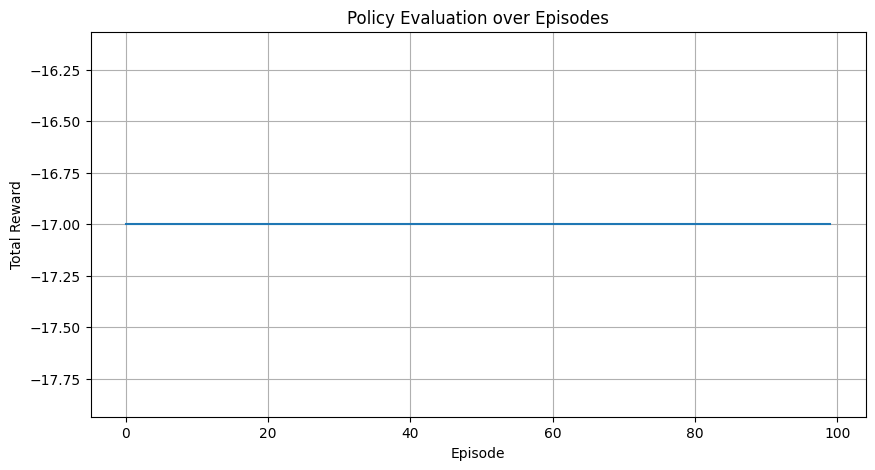

In [ ]:
env = CliffWalkingEnv()

# First Visit MC
mc_first = MonteCarlo(env, method="first")
mc_first.learning(episodes=1000)
evaluate_policy(env, mc_first.q_values, n=100)

# Every Visit MC
mc_every = MonteCarlo(env, method="every")
mc_every.learning(episodes=1000)
evaluate_policy(env, mc_every.q_values, n=100)


### **2.1 E: (1 Point)** Train one first visit and one every visit MC for 1000 episodes. Every 100 training episodes, evaluate the current policy by running 100 test episodes. Record the average cumulative reward from those episodes. Plot the development of the rewards of both versions in two separate graphs.


In [ ]:
import matplotlib.pyplot as plt

def train_and_evaluate(env, method, total_episodes=1000, eval_interval=100, eval_runs=100):
    learner = MonteCarlo(env, method=method)
    avg_rewards = []

    for ep in range(0, total_episodes + 1, eval_interval):
        if ep > 0:
            learner.learning(eval_interval)

        # Evaluate current policy
        total_reward = 0
        for _ in range(eval_runs):
            state = env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = np.argmax(learner.q_values[state])
                state, reward, done, _ = env.step(action)
                episode_reward += reward

            total_reward += episode_reward

        avg_reward = total_reward / eval_runs
        avg_rewards.append(avg_reward)
        print(f"{method.title()} Visit - Episode {ep}: Avg Reward = {avg_reward}")

    return avg_rewards


# Train both learners and collect reward data
env1 = CliffWalkingEnv()
rewards_first = train_and_evaluate(env1, method="first")

env2 = CliffWalkingEnv()
rewards_every = train_and_evaluate(env2, method="every")

In [ ]:
# Plot for First-Visit MC
plt.figure(figsize=(10, 5))
plt.plot(range(0, 1001, 100), rewards_first, marker='o')
plt.title('First-Visit Monte Carlo: Reward over Time')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward (100 test episodes)')
plt.grid(True)
plt.show()

# Plot for Every-Visit MC
plt.figure(figsize=(10, 5))
plt.plot(range(0, 1001, 100), rewards_every, marker='o', color='orange')
plt.title('Every-Visit Monte Carlo: Reward over Time')
plt.xlabel('Training Episodes')
plt.ylabel('Average Reward (100 test episodes)')
plt.grid(True)
plt.show()

---
# Problem 2.2: Temporal Difference Learning (10 Points)

In this exercise, we use the frozen lake environment of the gymnasium framework to implement both temporal difference algorithms from the lecture. During the tasks, think about the following questions regarding the two algorithms. (You do not need to hand in answers to the questions, this is meant to guide your own understanding.)

- Which agent reaches the goal (terminal state) faster?
- How do the two methods differ with regard to the obtained returns?
- Which algorithm learns faster and why?

Hand in the final code of the whole exercise as well as a csv-file of the final state-action-values of each subtask.
**Make sure to include the environment name, number of episodes, and the update rule in the csv-file names.**

### **2.2 A: (4 Points)** Read through the [documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) and implement both the SARSA-Algorithms and the Q-Learning by Watkins in the cell below. Do not modify the function parameters and the returned values. 
   The base configuration of the agent for the experiments should be as follows:
   - $epsilon\_decay = 1.0$
   - $gamma = 1.0$ (the discount factor)
   - Initial Q-values $init\_value = 0.0$ and $alpha= 0.1$ (learning rate)
   Test your implementation with the frozen lake environment for 2000 episodes and give out the final state-action-values.

In [4]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 262.6 kB/s eta 0:00:02
   --------- ----------------------------- 71.7/294.9 kB 393.8 kB/s eta 0:00:01
   ------------------------------- -------- 235.5/294.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install gymnasium

  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-1.1.1-py3-none-any.whl (965 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


SARSA Q-values:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


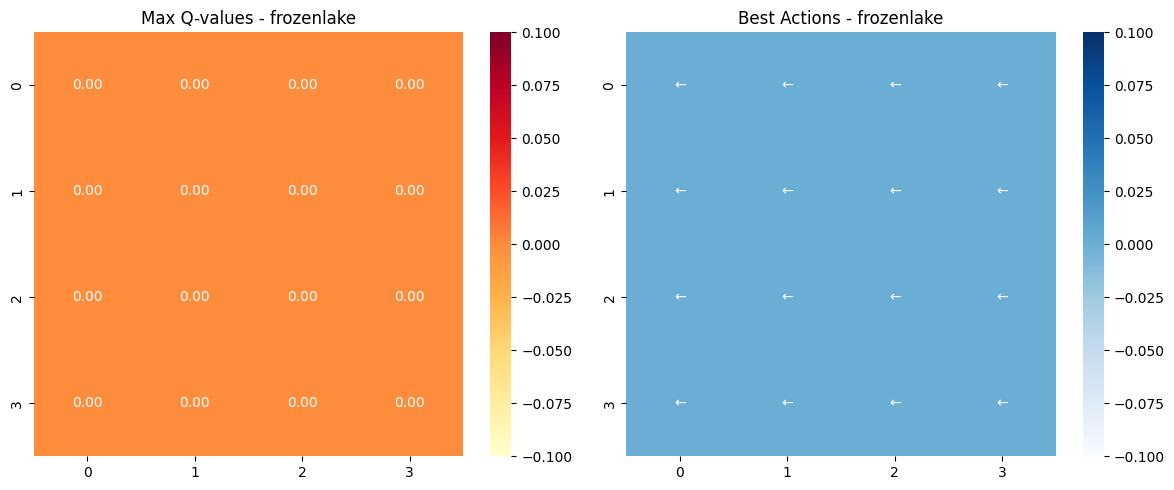


Q-Learning Q-values:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


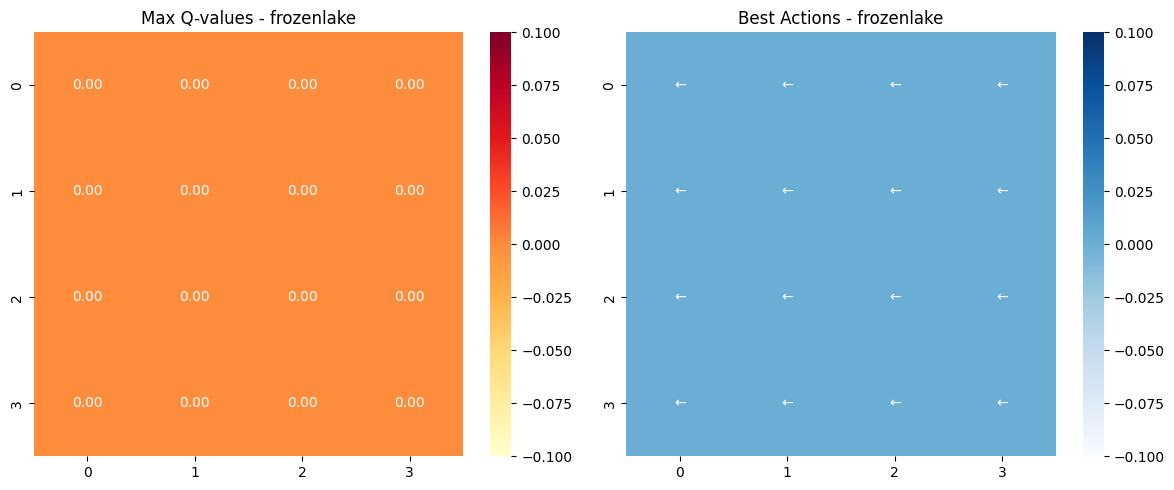

In [21]:
import numpy as np
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import gymnasium as gym

class TDLearning:
    def __init__(self, env, env_name="frozenlake"):
        self.env = env
        self.env_name = env_name
        self.action_states = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def e_greedy(self, state, epsilon):
        # Exploration-exploitation trade-off
        if np.random.random() < epsilon:
            # Explore: choose random action
            action = self.env.action_space.sample()
        else:
            # Exploit: choose best action based on Q-values
            action = np.argmax(self.action_states[state])
        return action
    
    def learning(self, episodes, update_rule='SARSA', alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=1.0):
        if update_rule not in ['SARSA', 'WatkinsQ']:
            sys.exit('Unknown update_rule, use either \'SARSA\' or \'WatkinsQ\' !')
        
        # Initialize Q-values
        self.action_states = np.ones((self.env.observation_space.n, self.env.action_space.n)) * init_value
        trajectories = []
        
        for episode in range(episodes):
            state, _ = self.env.reset()
            trajectory = []
            
            # Choose initial action
            action = self.e_greedy(state, epsilon)
            
            done = False
            episode_reward = 0
            
            while not done:
                # Take action and observe next state
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
                
                # Choose next action
                next_action = self.e_greedy(next_state, epsilon)
                
                # Update Q-values
                if update_rule == 'SARSA':
                    # SARSA update: Q(s,a) = Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
                    self.action_states[state, action] += alpha * (
                        reward + gamma * self.action_states[next_state, next_action] - self.action_states[state, action]
                    )
                elif update_rule == 'WatkinsQ':
                    # Q-learning update: Q(s,a) = Q(s,a) + α[r + γ*max_a'Q(s',a') - Q(s,a)]
                    if done:
                        self.action_states[state, action] += alpha * (
                            reward - self.action_states[state, action]
                        )
                    else:
                        self.action_states[state, action] += alpha * (
                            reward + gamma * np.max(self.action_states[next_state]) - self.action_states[state, action]
                        )
                
                trajectory.append((state, action, reward, next_state))
                state = next_state
                action = next_action
            
            trajectories.append(trajectory)
            
            # Decay epsilon
            epsilon *= epsilon_decay
        
        return self.action_states, trajectories
        
    def plot_q_values_map(self, map_size):
        # Visualize the learned Q-values
        if self.env_name == "frozenlake":
            # For FrozenLake, we'll show the best action for each state
            best_actions = np.argmax(self.action_states, axis=1)
            
            # Reshape to grid format
            best_actions_grid = best_actions.reshape(map_size)
            
            # Create action map
            action_map = {0: "←", 1: "↓", 2: "→", 3: "↑"}
            action_labels = np.vectorize(action_map.get)(best_actions_grid)
            
            # Create heatmap of max Q-values
            max_q_values = np.max(self.action_states, axis=1).reshape(map_size)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Plot Q-values heatmap
            sns.heatmap(max_q_values, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax1)
            ax1.set_title(f"Max Q-values - {self.env_name}")
            
            # Plot best actions
            sns.heatmap(max_q_values, annot=action_labels, fmt="", cmap="Blues", ax=ax2)
            ax2.set_title(f"Best Actions - {self.env_name}")
            
            plt.tight_layout()
            plt.show()
        
     
        elif self.env_name == "cliffwalking":
            # For CliffWalking, we need to handle the different grid shape
            best_actions = np.argmax(self.action_states, axis=1)
            best_actions_grid = best_actions.reshape(map_size)
            
            action_map = {0: "↑", 1: "→", 2: "↓", 3: "←"}
            action_labels = np.vectorize(action_map.get)(best_actions_grid)
            
            max_q_values = np.max(self.action_states, axis=1).reshape(map_size)
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
            
            # Plot Q-values heatmap
            sns.heatmap(max_q_values, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax1)
            ax1.set_title(f"Max Q-values - {self.env_name}")
            
            # Plot best actions
            sns.heatmap(max_q_values, annot=action_labels, fmt="", cmap="Blues", ax=ax2)
            ax2.set_title(f"Best Actions - {self.env_name}")
            
            plt.tight_layout()
            plt.show()

env = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=None, map_name="4x4", is_slippery=False)
learner = TDLearning(env)

# Train with SARSA
sarsa_q_values, sarsa_trajectories = learner.learning(2000, "SARSA", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=0.995)
print("SARSA Q-values:\n", sarsa_q_values)
learner.plot_q_values_map((4, 4))

# Train with Q-Learning
learner2 = TDLearning(env)
qlearning_q_values, qlearning_trajectories = learner2.learning(2000, "WatkinsQ", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=0.995)
print("\nQ-Learning Q-values:\n", qlearning_q_values)
learner2.plot_q_values_map((4, 4))

# Save results to CSV
import pandas as pd

# SARSA results
sarsa_df = pd.DataFrame(sarsa_q_values)
sarsa_df.to_csv("frozenlake_sarsa_2000episodes.csv", index=True)

# Q-Learning results
qlearning_df = pd.DataFrame(qlearning_q_values)
qlearning_df.to_csv("frozenlake_qlearning_2000episodes.csv", index=True)

env.close()

 ### **2.2 B: (1 Point)** Run the test with the `is_slippery` parameter set to True. You may need to increase the number of episodes to 5000 to see the difference. Print out the state-action-values. Think about the results.

SARSA Q-values (slippery):
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


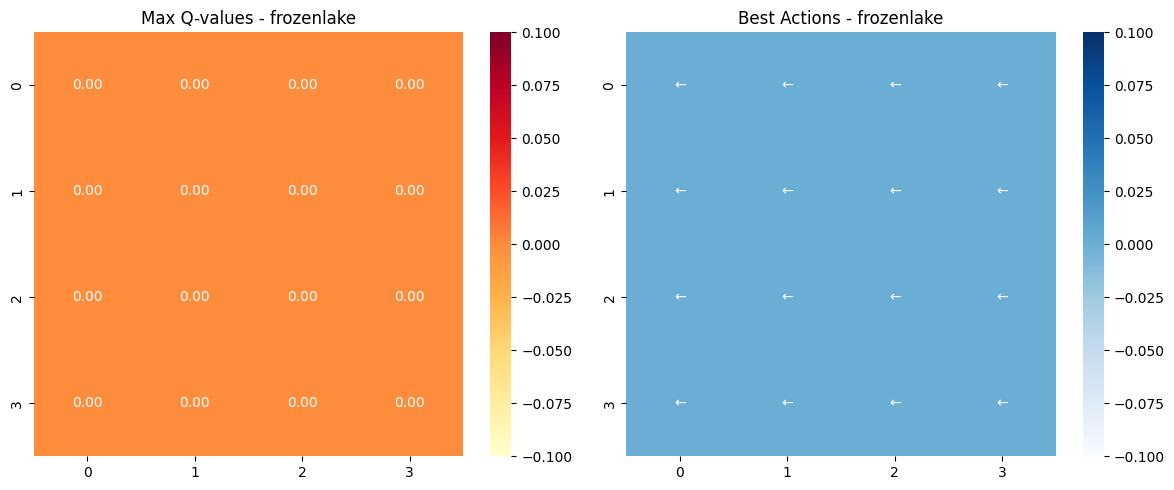


Q-Learning Q-values (slippery):
 [[7.28389177e-01 5.90588366e-01 6.12052228e-01 5.96224000e-01]
 [2.10881442e-01 3.18092188e-01 2.63677161e-01 6.12782894e-01]
 [5.26305089e-01 2.13933280e-01 2.55134601e-01 2.70867622e-01]
 [9.40073902e-02 9.26309439e-03 5.75772320e-03 7.85027670e-04]
 [6.93837792e-01 4.17249404e-01 4.31745209e-01 3.68564860e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.66290987e-01 1.57510194e-01 4.47582289e-01 9.61629880e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.67895775e-01 5.85259861e-01 3.38905732e-01 7.39056486e-01]
 [4.65667601e-01 7.49206200e-01 4.02840744e-01 5.35287469e-01]
 [7.05612460e-01 4.05219549e-01 2.94764605e-01 2.85963705e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.44532579e-01 6.33146876e-01 7.96226403e-01 3.28943032e-01]
 [7.56923927e-01 9.35498939e-01 7.57120009e-01 7.30499854e-01]
 [0.00000000e+00 0.00

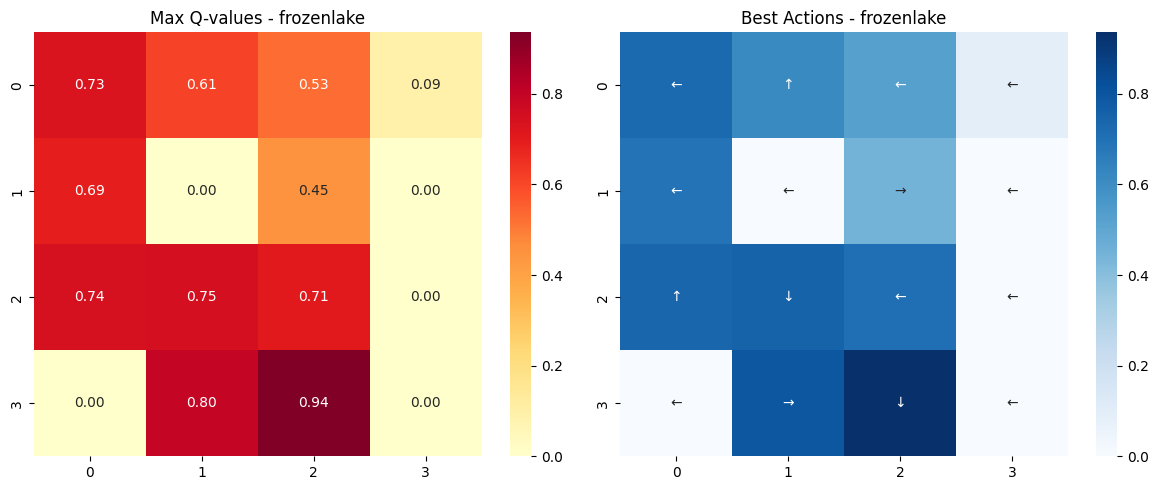

In [22]:
import numpy as np
import gymnasium as gym

env_slippery = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=None, map_name="4x4", is_slippery=True)
learner_slippery = TDLearning(env_slippery)

# Train with SARSA on slippery environment
sarsa_q_values_slippery, _ = learner_slippery.learning(5000, "SARSA", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=0.998)
print("SARSA Q-values (slippery):\n", sarsa_q_values_slippery)
learner_slippery.plot_q_values_map((4, 4))

# Train with Q-Learning on slippery environment
learner_slippery2 = TDLearning(env_slippery)
qlearning_q_values_slippery, _ = learner_slippery2.learning(5000, "WatkinsQ", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=0.998)
print("\nQ-Learning Q-values (slippery):\n", qlearning_q_values_slippery)
learner_slippery2.plot_q_values_map((4, 4))

# Save slippery results
sarsa_slippery_df = pd.DataFrame(sarsa_q_values_slippery)
sarsa_slippery_df.to_csv("frozenlake_slippery_sarsa_5000episodes.csv", index=True)

qlearning_slippery_df = pd.DataFrame(qlearning_q_values_slippery)
qlearning_slippery_df.to_csv("frozenlake_slippery_qlearning_5000episodes.csv", index=True)

env_slippery.close()

### **2.3 C: (1 Point)** Set the size of the frozen lake environment to 8x8 with the `is_slippery` parameter set to False. Increase the number of episodes until you see a meaningful result in the state-action-values (This might not work). What are your thoughts on this? How could you improve the learning time?

SARSA Q-values (8x8):
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


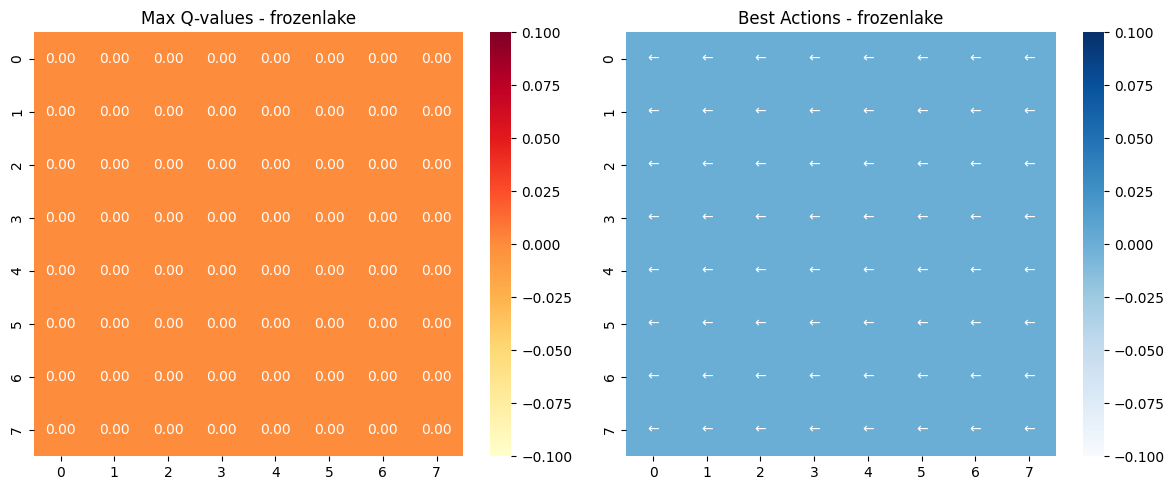


Q-Learning Q-values (8x8):
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


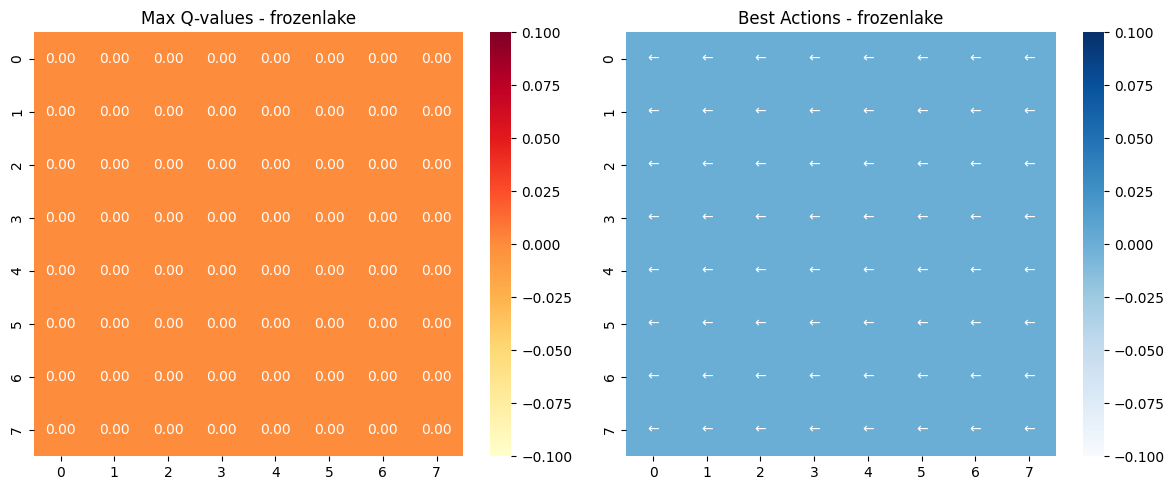

In [23]:
env_8x8 = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=None, map_name="8x8", is_slippery=False)
learner_8x8 = TDLearning(env_8x8)

# Train with more episodes
sarsa_q_values_8x8, _ = learner_8x8.learning(10000, "SARSA", alpha=0.1, gamma=0.95, init_value=0.0, epsilon=0.8, epsilon_decay=0.9995)
print("SARSA Q-values (8x8):\n", sarsa_q_values_8x8)
learner_8x8.plot_q_values_map((8, 8))

# Train with Q-Learning
learner_8x8_2 = TDLearning(env_8x8)
qlearning_q_values_8x8, _ = learner_8x8_2.learning(10000, "WatkinsQ", alpha=0.1, gamma=0.95, init_value=0.0, epsilon=0.8, epsilon_decay=0.9995)
print("\nQ-Learning Q-values (8x8):\n", qlearning_q_values_8x8)
learner_8x8_2.plot_q_values_map((8, 8))

# Save 8x8 results
sarsa_8x8_df = pd.DataFrame(sarsa_q_values_8x8)
sarsa_8x8_df.to_csv("frozenlake_8x8_sarsa_10000episodes.csv", index=True)

qlearning_8x8_df = pd.DataFrame(qlearning_q_values_8x8)
qlearning_8x8_df.to_csv("frozenlake_8x8_qlearning_10000episodes.csv", index=True)

env_8x8.close()

### **2.4 D: (2 Points)** Adjust your implementation so that it also works with the [cliff walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment. Test it with 200, 500, and 1000 episodes. Why is the progress for this environment faster? How do the best actions change with the increased number of episodes? Save the results of the 1000 episode test.


=== Training with 200 episodes ===
SARSA trained with 200 episodes


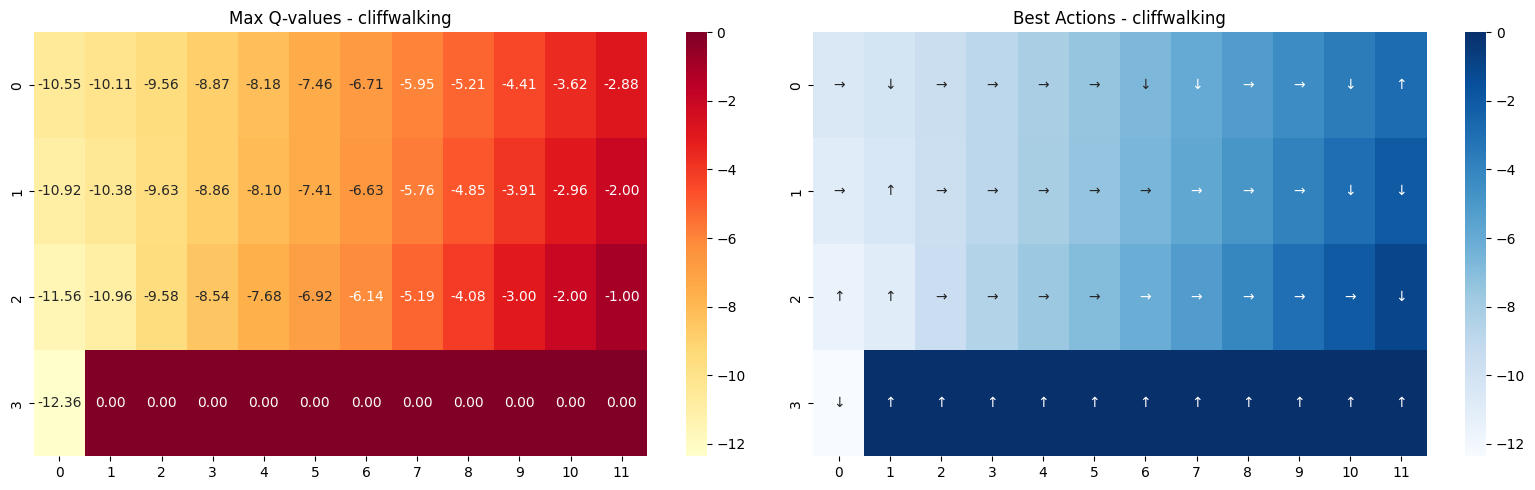

Q-Learning trained with 200 episodes


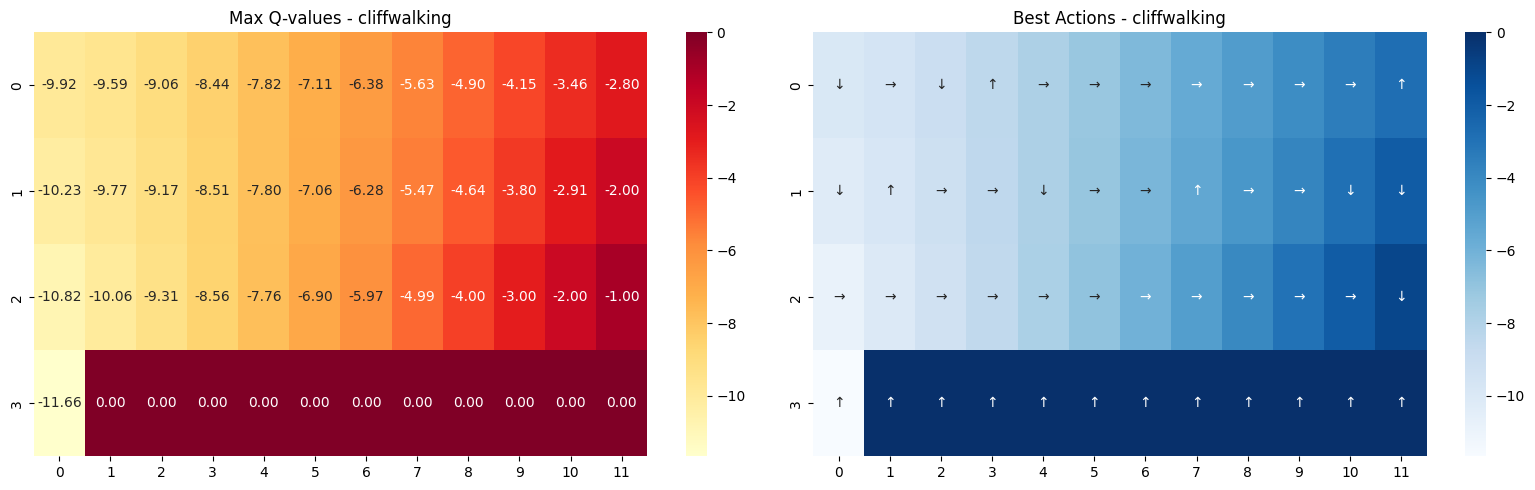


=== Training with 500 episodes ===
SARSA trained with 500 episodes


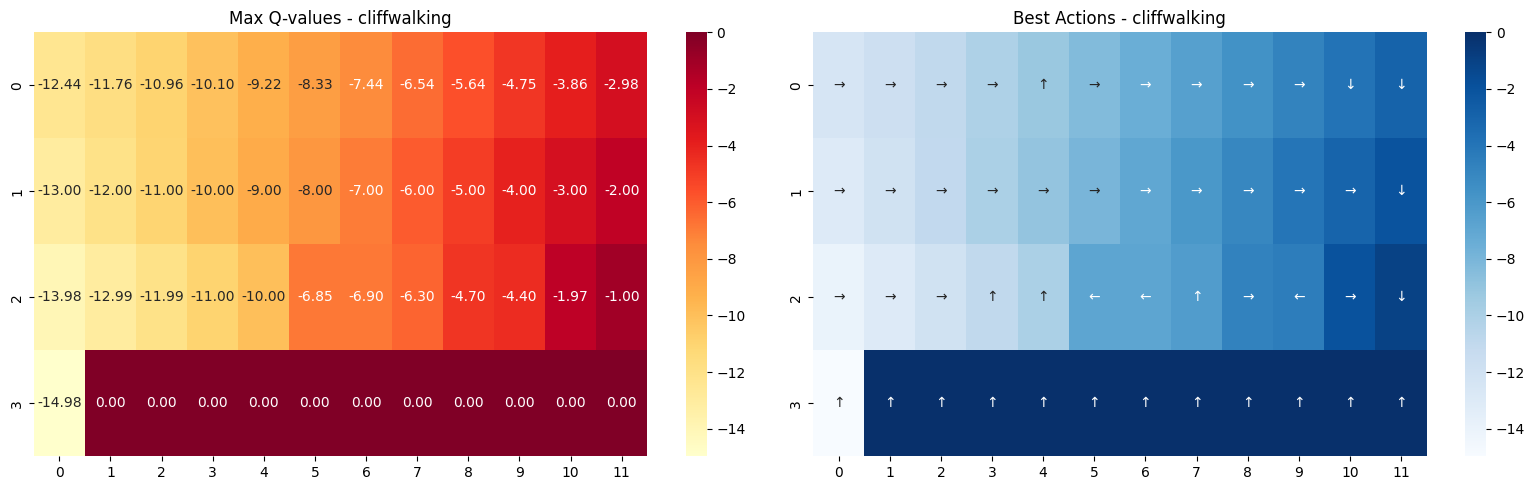

Q-Learning trained with 500 episodes


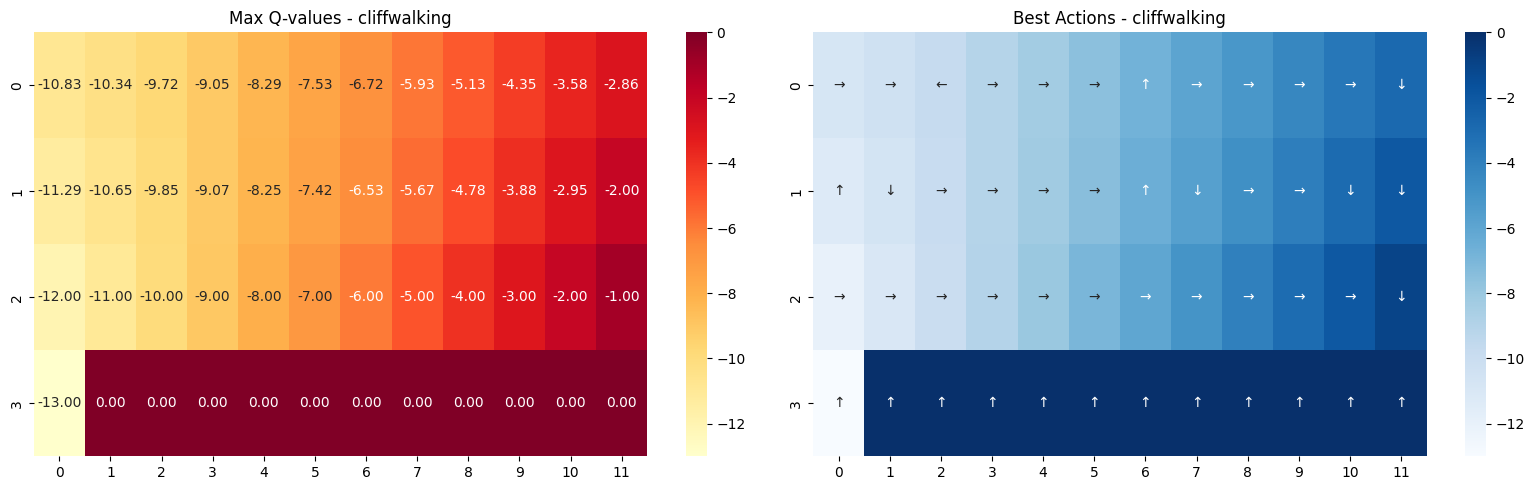


=== Training with 1000 episodes ===
SARSA trained with 1000 episodes


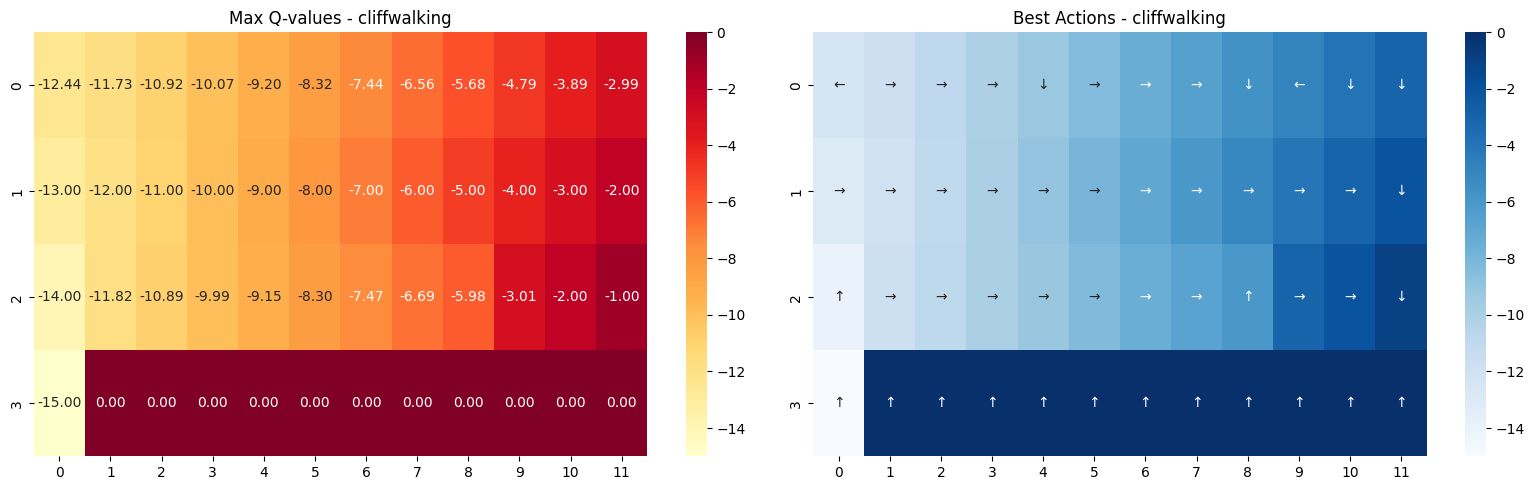

Q-Learning trained with 1000 episodes


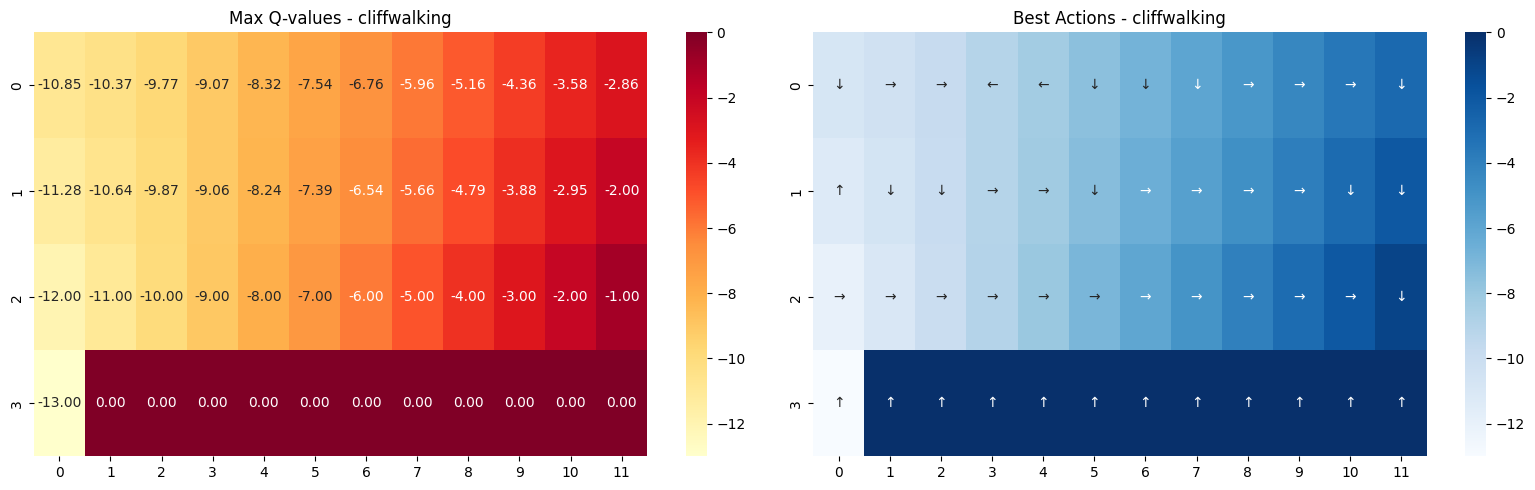

In [24]:
env_cliff = gym.make('CliffWalking-v0', render_mode="rgb_array")
learner_cliff = TDLearning(env_cliff, "cliffwalking")

# Test with different episode counts
episode_counts = [200, 500, 1000]

for episodes in episode_counts:
    print(f"\n=== Training with {episodes} episodes ===")
    
    # SARSA
    learner_cliff_sarsa = TDLearning(env_cliff, "cliffwalking")
    sarsa_q_cliff, _ = learner_cliff_sarsa.learning(episodes, "SARSA", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.1, epsilon_decay=0.99)
    print(f"SARSA trained with {episodes} episodes")
    learner_cliff_sarsa.plot_q_values_map((4, 12))
    
    # Q-Learning
    learner_cliff_q = TDLearning(env_cliff, "cliffwalking")
    q_q_cliff, _ = learner_cliff_q.learning(episodes, "WatkinsQ", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.1, epsilon_decay=0.99)
    print(f"Q-Learning trained with {episodes} episodes")
    learner_cliff_q.plot_q_values_map((4, 12))
    
    # Save the 1000 episode results
    if episodes == 1000:
        sarsa_cliff_df = pd.DataFrame(sarsa_q_cliff)
        sarsa_cliff_df.to_csv("cliffwalking_sarsa_1000episodes.csv", index=True)
        
        q_cliff_df = pd.DataFrame(q_q_cliff)
        q_cliff_df.to_csv("cliffwalking_qlearning_1000episodes.csv", index=True)

env_cliff.close()

### **2.4 E: (2 Points)** Add a visualization function which plots the final state next to the grid where the best directions are shown (see Figure below).Run the tests again and verify that the visualization works properly for all settings. Include one graphic for both the frozen lake and the cliff walking.
<p style="text-align:center;">
<img src="frozen.png" alt="Frozen Lake results with WatkinsQ and 2000 episodes" width="900">
</p>
   *Hint: You can use the heatmap from the seaborn package with annotations.*

=== Final FrozenLake Visualization ===


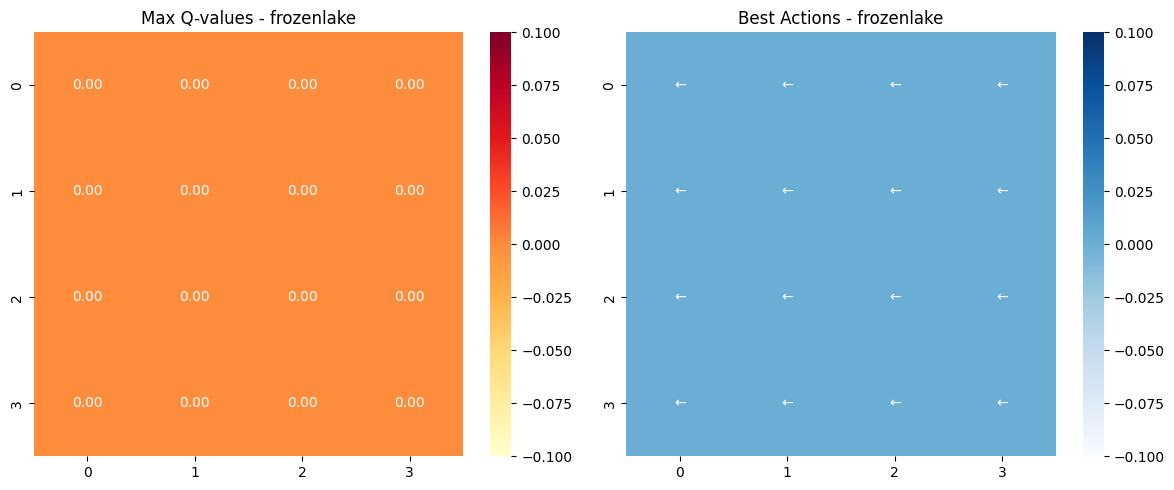


=== Final CliffWalking Visualization ===


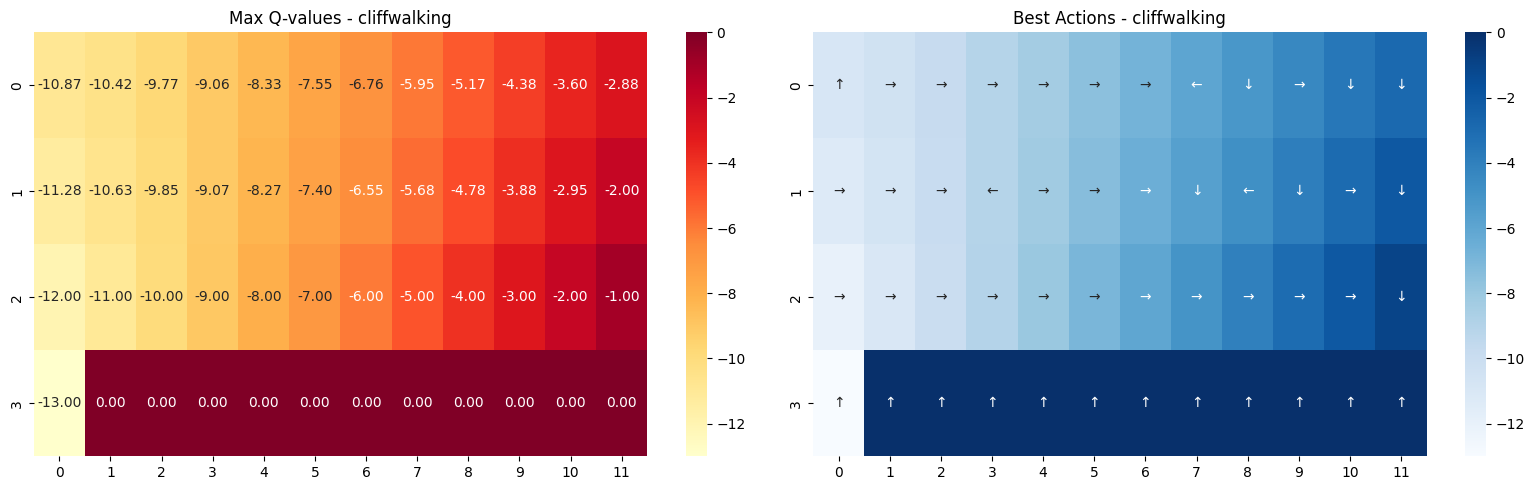

In [25]:
# Create final visualizations for both environments

# FrozenLake visualization
print("=== Final FrozenLake Visualization ===")
env_viz_frozen = gym.make('FrozenLake-v1', render_mode="rgb_array", desc=None, map_name="4x4", is_slippery=False)
learner_viz_frozen = TDLearning(env_viz_frozen)
q_values_viz_frozen, _ = learner_viz_frozen.learning(2000, "WatkinsQ", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.5, epsilon_decay=0.995)
learner_viz_frozen.plot_q_values_map((4, 4))

# CliffWalking visualization  
print("\n=== Final CliffWalking Visualization ===")
env_viz_cliff = gym.make('CliffWalking-v0', render_mode="rgb_array")
learner_viz_cliff = TDLearning(env_viz_cliff, "cliffwalking")
q_values_viz_cliff, _ = learner_viz_cliff.learning(1000, "WatkinsQ", alpha=0.1, gamma=1.0, init_value=0.0, epsilon=0.1, epsilon_decay=0.99)
learner_viz_cliff.plot_q_values_map((4, 12))

env_viz_frozen.close()
env_viz_cliff.close()

<div align="center" style="font-family: 'Garamond', serif; color: #333333;">
    <hr style="border-top: 2px solid #8b0000; width: 100%;">
    <p style="color: #6c757d;">
        Please upload your submission via StudIP by 23:59 on May 14, 2025. If you encounter any issues with the upload process, please contact me in advance at <a href="mailto:laux@uni-bremen.de" style="color: #8b0000;">laux@uni-bremen.de</a>. Your submission must include:
    </p>
    <ul style="list-style-type: none; color: #6c757d;">
        <li>&#9472; A well-documented, precompiled notebook, containing the entire solution(s) along with outputs and plots if applicable</li>
        <li>&#9472; A markdown cell with the names and e-mail addresses of the contributing team members</li>
    </ul>
    <hr style="border-top: 2px solid #8b0000; width: 100%;">
</div>